In [2]:
import json
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds

2025-03-02 10:33:04.247304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740936785.896976   40846 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740936786.318568   40846 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 10:33:10.460073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Read Data

In [8]:
data = pd.read_json("../data/raw/oracle-cards-20250127220801.json")

In [10]:
data

,object,id,oracle_id,multiverse_ids,cardmarket_id,name,lang,released_at,uri,scryfall_uri,...,produced_mana,card_faces,tcgplayer_etched_id,loyalty,life_modifier,hand_modifier,attraction_lights,color_indicator,content_warning,defense
0,card,a471b306-4941-4e46-a0cb-d92895c16f8a,00037840-6089-42ec-8c5c-281f9f474504,[],807933.0,"Nissa, Worldsoul Speaker",en,2025-02-14,https://api.scryfall.com/cards/a471b306-4941-4...,https://scryfall.com/card/drc/13/nissa-worldso...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,86bf43b1-8d4e-4759-bb2d-0b2e03ba7012,0004ebd0-dfd6-4276-b4a6-de0003e94237,[15862],3081.0,Static Orb,en,2001-04-11,https://api.scryfall.com/cards/86bf43b1-8d4e-4...,https://scryfall.com/card/7ed/319/static-orb?u...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,7050735c-b232-47a6-a342-01795bfd0d46,0006faf6-7a61-426c-9034-579f2cfcfa83,[370780],262945.0,Sensory Deprivation,en,2013-07-19,https://api.scryfall.com/cards/7050735c-b232-4...,https://scryfall.com/card/m14/71/sensory-depri...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,e718b21b-46d1-4844-985c-52745657b1ac,0007c283-5b7a-4c00-9ca1-b455c8dff8c3,[470580],391692.0,Road of Return,en,2019-08-23,https://api.scryfall.com/cards/e718b21b-46d1-4...,https://scryfall.com/card/c19/34/road-of-retur...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,036ef8c9-72ac-46ce-af07-83b79d736538,000d5588-5a4c-434e-988d-396632ade42c,[83282],12551.0,Storm Crow,en,2005-07-29,https://api.scryfall.com/cards/036ef8c9-72ac-4...,https://scryfall.com/card/9ed/100/storm-crow?u...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33826,card,d6695fa8-881c-407c-91d9-3ac770372d35,fffa9334-3576-4f70-9605-2ad062cdbc69,[430770],298834.0,Without Weakness,en,2017-07-14,https://api.scryfall.com/cards/d6695fa8-881c-4...,https://scryfall.com/card/hou/81/without-weakn...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33827,card,4d5edf4f-5695-42fc-9e57-c4faef60fbc3,fffaa634-42a0-4038-b027-24f28754fec7,[571548],665173.0,Firesong and Sunspeaker,en,2022-07-08,https://api.scryfall.com/cards/4d5edf4f-5695-4...,https://scryfall.com/card/2x2/215/firesong-and...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33828,card,22a6a5f1-1405-4efb-af3e-e1f58d664e99,fffcb71f-e802-436e-917d-eaa6607ab74f,"[503766, 503767]",530502.0,"Toralf, God of Fury // Toralf's Hammer",en,2021-02-05,https://api.scryfall.com/cards/22a6a5f1-1405-4...,https://scryfall.com/card/khm/154/toralf-god-o...,...,NaN,"[{'object': 'card_face', 'name': 'Toralf, God ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33829,card,09f06f55-7918-46c4-80ff-0bf39e091a4a,fffdc2ac-bde4-4e4c-a5bd-0e6c6e49ad91,[430833],298282.0,"Samut, the Tested",en,2017-07-14,https://api.scryfall.com/cards/09f06f55-7918-4...,https://scryfall.com/card/hou/144/samut-the-te...,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'cardmarket_id', 'name',
       'lang', 'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil',
       'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id',
       'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri',
       'scryfall_set_uri', 'rulings_uri', 'prints_search_uri',
       'collector_number', 'digital', 'rarity', 'watermark', 'flavor_text',
       'card_back_id', 'artist', 'artist_ids', 'illustration_id',
       'border_color', 'frame', 'frame_effects', 'security_stamp', 'full_art',
       'textless', 'booster', 'story_spotlight', 'preview', 'prices',
       'related_uris', 'purchase_uris', 'mtgo_id', 'mtgo_foil_id',
       'tcgplayer_id', 'edhrec_rank', 'penny_rank', 'arena_id',

In [24]:
selected_df = data[["object", "name", "layout", "mana_cost", "type_line", "oracle_text", "power", "toughness", "colors", "color_identity", "keywords", "loyalty", "defense", "legalities"]]

In [30]:
selected_df

,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities
0,card,"Nissa, Worldsoul Speaker",normal,{3}{G},Legendary Creature — Elf Druid,"Landfall — Whenever a land you control enters,...",3,3,[G],[G],[Landfall],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33828,card,"Toralf, God of Fury // Toralf's Hammer",modal_dfc,NaN,Legendary Creature — God // Legendary Artifact...,NaN,NaN,NaN,NaN,[R],"[Trample, Equip]",NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."


# Filter Data

In [44]:
def take_only_legal_cards(legalities):
    for key in legalities.keys():
        if legalities[key] == "legal":
            return True
    return False

In [45]:
is_legal = selected_df["legalities"].apply(take_only_legal_cards)

In [46]:
is_legal

0        False
1         True
2         True
3         True
4         True
         ...  
33826     True
33827     True
33828     True
33829     True
33830     True
Name: legalities, Length: 33831, dtype: bool

In [47]:
legal_cards = selected_df[is_legal == True]

In [48]:
legal_cards

,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities
1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33828,card,"Toralf, God of Fury // Toralf's Hammer",modal_dfc,NaN,Legendary Creature — God // Legendary Artifact...,NaN,NaN,NaN,NaN,[R],"[Trample, Equip]",NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."


In [50]:
legal_cards["layout"].unique()

array(['normal', 'class', 'saga', 'meld', 'prototype', 'transform',
       'modal_dfc', 'split', 'adventure', 'mutate', 'leveler', 'case',
       'flip', 'art_series'], dtype=object)

There are a few conditions that we want to scope our project to:
1. Cards with standardized art frames. This means that cards such as classes, sagas, split, and case are not relevant.
2. Cards must have a single face. This means that double faced cards such as transform, modal_dfc, and flip are not relevant.

In [57]:
relevant_cards = legal_cards[selected_df["layout"].isin(["normal", "meld", "prototype", "mutate", "leveler"])]

/tmp/ipykernel_5111/1617211888.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_cards = legal_cards[selected_df["layout"].isin(["normal", "meld", "prototype", "mutate", "leveler"])]


In [58]:
relevant_cards.reset_index(inplace=True)

In [59]:
relevant_cards

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities
0,1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
1,2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
2,3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
3,4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
4,5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28074,33825,card,Devoted Hero,normal,{W},Creature — Elf Soldier,,1,2,[W],[W],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
28075,33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
28076,33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."
28077,33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal..."


In [63]:
relevant_cards.to_csv("../data/interim/relevant_cards.csv")

# Understand card text

In [60]:
relevant_cards["oracle_text"]

0        As long as Static Orb is untapped, players can...
1         Enchant creature\nEnchanted creature gets -3/-0.
2        Choose one —\n• Return target permanent card f...
3        Flying (This creature can't be blocked except ...
4        Whenever Snarlfang Vermin deals combat damage ...
                               ...                        
28074                                                     
28075    Target creature you control gains indestructib...
28076    Red instant and sorcery spells you control hav...
28077    +1: Up to one target creature gains double str...
28078                      All Sliver creatures get +1/+1.
Name: oracle_text, Length: 28079, dtype: object

In [61]:
ORACLE_TEXT_CHARACTERS = set()

def parse_characters(entry):
    for char in entry:
        ORACLE_TEXT_CHARACTERS.add(char)

relevant_cards["oracle_text"].apply(parse_characters)
ORACLE_TEXT_CHARACTERS

{'\n',
 ' ',
 '!',
 '"',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 'É',
 'á',
 'â',
 'é',
 'í',
 'ï',
 'ñ',
 'ó',
 'ö',
 'ú',
 'û',
 '—',
 '•',
 '−',
 '꞉'}

# Format card text

In [71]:
CARD_TEXT_FORMAT = "<CARD_NAME> {name} <MANA_COST> {mana_cost} <TYPE_LINE> {type_line} <ORACLE_TEXT> {oracle_text}"
POWER_TOUGHNESS_FORMAT = "<POWER> {power} <TOUGHNESS> {toughness}"
LOYALTY_FORMAT = "<LOYALTY> {loyalty}"

In [72]:
def format_card_text(entry):
    card_text = CARD_TEXT_FORMAT.format(
        name = entry["name"],
        mana_cost = entry["mana_cost"],
        type_line = entry["type_line"],
        oracle_text = entry["oracle_text"])

    if "creature" in entry["type_line"].lower():
        power_toughness = POWER_TOUGHNESS_FORMAT.format(
            power = entry["power"],
            toughness = entry["toughness"])
        card_text += " " + power_toughness
    elif "planeswalker" in entry["type_line"].lower():
        loyalty = LOYALTY_FORMAT.format(
            loyalty = entry["loyalty"])
        card_text += " " + loyalty

    return card_text

In [77]:
card_texts = relevant_cards.apply(format_card_text, axis=1)

In [78]:
card_texts

0        <CARD_NAME> Static Orb <MANA_COST> {3} <TYPE_L...
1        <CARD_NAME> Sensory Deprivation <MANA_COST> {U...
2        <CARD_NAME> Road of Return <MANA_COST> {G}{G} ...
3        <CARD_NAME> Storm Crow <MANA_COST> {1}{U} <TYP...
4        <CARD_NAME> Snarlfang Vermin <MANA_COST> {B} <...
                               ...                        
28074    <CARD_NAME> Devoted Hero <MANA_COST> {W} <TYPE...
28075    <CARD_NAME> Without Weakness <MANA_COST> {1}{B...
28076    <CARD_NAME> Firesong and Sunspeaker <MANA_COST...
28077    <CARD_NAME> Samut, the Tested <MANA_COST> {2}{...
28078    <CARD_NAME> Sinew Sliver <MANA_COST> {1}{W} <T...
Length: 28079, dtype: object

In [80]:
relevant_cards = relevant_cards.assign(card_text=card_texts)

In [88]:
relevant_cards

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities,card_text
0,1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Static Orb <MANA_COST> {3} <TYPE_L...
1,2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Sensory Deprivation <MANA_COST> {U...
2,3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Road of Return <MANA_COST> {G}{G} ...
3,4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Storm Crow <MANA_COST> {1}{U} <TYP...
4,5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Snarlfang Vermin <MANA_COST> {B} <...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28074,33825,card,Devoted Hero,normal,{W},Creature — Elf Soldier,,1,2,[W],[W],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Devoted Hero <MANA_COST> {W} <TYPE...
28075,33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Without Weakness <MANA_COST> {1}{B...
28076,33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Firesong and Sunspeaker <MANA_COST...
28077,33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal...","<CARD_NAME> Samut, the Tested <MANA_COST> {2}{..."


# Add Themes

In [121]:
with open("../data/processed/card_themes.json", 'r') as file:
    card_themes = file.read()

card_themes = json.loads(card_themes)

In [123]:
relevant_cards["themes"] = relevant_cards["name"].apply(lambda x: card_themes[x])

In [124]:
relevant_cards

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities,card_text,themes
0,1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Static Orb <MANA_COST> {3} <TYPE_L...,"[N Identity, Artifact, N Color, {3} Cost]"
1,2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Sensory Deprivation <MANA_COST> {U...,"[{U} Cost, Aura, Enchantment, U Identity, Crea..."
2,3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Road of Return <MANA_COST> {G}{G} ...,"[Entwine, G Identity, {G}{G} Cost, G Color, So..."
3,4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Storm Crow <MANA_COST> {1}{U} <TYP...,"[Token, Bird, Creature, Cost, Flying, U Ident..."
4,5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Snarlfang Vermin <MANA_COST> {B} <...,"[B Identity, Creature, Suspect, Rat, Creature ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28074,33825,card,Devoted Hero,normal,{W},Creature — Elf Soldier,,1,2,[W],[W],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Devoted Hero <MANA_COST> {W} <TYPE...,"[Creature, {W} Cost, Soldier, W Color, Elf, W ..."
28075,33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Without Weakness <MANA_COST> {1}{B...,"[B Identity, Indestructible, Cycling, Creature..."
28076,33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> Firesong and Sunspeaker <MANA_COST...,"[RW Identity, Lifelink, Damage, Creature, Mino..."
28077,33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal...","<CARD_NAME> Samut, the Tested <MANA_COST> {2}{...","[Damage, Double Strike, Planeswalker, {2}{R}{G..."


# Remove Card Name

We want to try removing card names. Card names will add a lot of unique tokens that don't show up within the text, and might make generating new cards a bit random. We might get more consistent results without the card name.

However, this is just a guess, so let's also produce card text with the card name in tact, so we can iterate with both name and no name models.

In [125]:
def substitute_card_names(entry):
    card_name = entry["name"]
    text = entry["card_text"]
    text = text.replace(card_name, "<name>")
    name_pieces = card_name.split(",")
    if len(name_pieces) > 1:
        main_name = name_pieces[0]
        text = text.replace(main_name, "<name>")

    entry["card_text"] = text
    return entry

In [126]:
relevant_cards_without_name = relevant_cards.apply(substitute_card_names, axis=1)

In [127]:
relevant_cards_without_name

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities,card_text,themes
0,1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {3} <TYPE_LINE>...,"[N Identity, Artifact, N Color, {3} Cost]"
1,2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {U} <TYPE_LINE>...,"[{U} Cost, Aura, Enchantment, U Identity, Crea..."
2,3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {G}{G} <TYPE_LI...,"[Entwine, G Identity, {G}{G} Cost, G Color, So..."
3,4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {1}{U} <TYPE_LI...,"[Token, Bird, Creature, Cost, Flying, U Ident..."
4,5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {B} <TYPE_LINE>...,"[B Identity, Creature, Suspect, Rat, Creature ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28074,33825,card,Devoted Hero,normal,{W},Creature — Elf Soldier,,1,2,[W],[W],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {W} <TYPE_LINE>...,"[Creature, {W} Cost, Soldier, W Color, Elf, W ..."
28075,33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {1}{B} <TYPE_LI...,"[B Identity, Indestructible, Cycling, Creature..."
28076,33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {4}{R}{W} <TYPE...,"[RW Identity, Lifelink, Damage, Creature, Mino..."
28077,33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {2}{R}{G} <TYPE...,"[Damage, Double Strike, Planeswalker, {2}{R}{G..."


In [128]:
relevant_cards[relevant_cards["name"] == "Lazav, Wearer of Faces"]

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities,card_text,themes
8588,10335,card,"Lazav, Wearer of Faces",normal,{U}{B},Legendary Creature — Shapeshifter Detective,"Whenever Lazav, Wearer of Faces attacks, exile...",2,3,"[B, U]","[B, U]",[Investigate],NaN,NaN,"{'standard': 'legal', 'future': 'legal', 'hist...","<CARD_NAME> Lazav, Wearer of Faces <MANA_COST>...","[Shapeshifter, Creature, Attacking, {U}{B} Cos..."


In [129]:
relevant_cards_without_name.loc[8588]["card_text"]

'<CARD_NAME> <name> <MANA_COST> {U}{B} <TYPE_LINE> Legendary Creature — Shapeshifter Detective <ORACLE_TEXT> Whenever <name> attacks, exile target card from a graveyard, then investigate. (Create a Clue token. It\'s an artifact with "{2}, Sacrifice this artifact: Draw a card.")\nWhenever you sacrifice a Clue, you may have <name> become a copy of a creature card exiled with it until end of turn. <POWER> 2 <TOUGHNESS> 3'

In [130]:
relevant_cards.to_csv("../data/interim/relevant_cards_with_text.csv")

In [131]:
relevant_cards_without_name.to_csv("../data/interim/relevant_cards_with_text_no_name.csv")

# Tokenize text

In [132]:
def preprocess_oracle_text(text):
    if pd.isna(text):
        return ""

    # Keep newlines as separate tokens
    text = text.replace('\n', ' \\n ')  # I don't think we need to capture all escape characters, just \n

    # Add spaces around mana symbols and other special patterns
    text = re.sub(r'(\{[^}]+\})', r' \1 ', text)  # Mana symbols like {G}, {2}, {U}
    text = re.sub(r'(−\d+)', r' \1 ', text)  # Planeswalker minus abilities
    text = re.sub(r'([.,:])', r' \1 ', text)  # Keep punctuation as separate tokens

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def mtg_tokenize(text):
    # Pattern matches:
    # 1. Escape sequences (\n)
    # 2. Mana symbols {X}, {R}, {2}, etc.
    # 3. Minus abilities for planeswalkers (−1, −2, etc.)
    # 4. Words (including hyphenated)
    # 5. Numbers
    # 6. Punctuation
    pattern = r'\\n|{[^}]+}|−\d+|[<>\w\'-]+|\d+|[.,:—\(\)]'
    tokens = re.findall(pattern, text)
    return tokens

In [133]:
example = relevant_cards_without_name["card_text"].iloc[8588]
example_processed = preprocess_oracle_text(example)
example_tokens = mtg_tokenize(example_processed)
example_tokens

['<CARD_NAME>',
 '<name>',
 '<MANA_COST>',
 '{U}',
 '{B}',
 '<TYPE_LINE>',
 'Legendary',
 'Creature',
 '—',
 'Shapeshifter',
 'Detective',
 '<ORACLE_TEXT>',
 'Whenever',
 '<name>',
 'attacks',
 ',',
 'exile',
 'target',
 'card',
 'from',
 'a',
 'graveyard',
 ',',
 'then',
 'investigate',
 '.',
 '(',
 'Create',
 'a',
 'Clue',
 'token',
 '.',
 "It's",
 'an',
 'artifact',
 'with',
 '{2}',
 ',',
 'Sacrifice',
 'this',
 'artifact',
 ':',
 'Draw',
 'a',
 'card',
 '.',
 ')',
 '\\n',
 'Whenever',
 'you',
 'sacrifice',
 'a',
 'Clue',
 ',',
 'you',
 'may',
 'have',
 '<name>',
 'become',
 'a',
 'copy',
 'of',
 'a',
 'creature',
 'card',
 'exiled',
 'with',
 'it',
 'until',
 'end',
 'of',
 'turn',
 '.',
 '<POWER>',
 '2',
 '<TOUGHNESS>',
 '3']

In [134]:
processed_texts = relevant_cards_without_name["card_text"].apply(preprocess_oracle_text)

In [140]:
relevant_cards_without_name["card_text_tokens"] = processed_texts.apply(mtg_tokenize)

In [141]:
relevant_cards_without_name

,index,object,name,layout,mana_cost,type_line,oracle_text,power,toughness,colors,color_identity,keywords,loyalty,defense,legalities,card_text,themes,card_text_tokens
0,1,card,Static Orb,normal,{3},Artifact,"As long as Static Orb is untapped, players can...",NaN,NaN,[],[],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {3} <TYPE_LINE>...,"[N Identity, Artifact, N Color, {3} Cost]","[<CARD_NAME>, <name>, <MANA_COST>, {3}, <TYPE_..."
1,2,card,Sensory Deprivation,normal,{U},Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,NaN,NaN,[U],[U],[Enchant],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {U} <TYPE_LINE>...,"[{U} Cost, Aura, Enchantment, U Identity, Crea...","[<CARD_NAME>, <name>, <MANA_COST>, {U}, <TYPE_..."
2,3,card,Road of Return,normal,{G}{G},Sorcery,Choose one —\n• Return target permanent card f...,NaN,NaN,[G],[G],[Entwine],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {G}{G} <TYPE_LI...,"[Entwine, G Identity, {G}{G} Cost, G Color, So...","[<CARD_NAME>, <name>, <MANA_COST>, {G}, {G}, <..."
3,4,card,Storm Crow,normal,{1}{U},Creature — Bird,Flying (This creature can't be blocked except ...,1,2,[U],[U],[Flying],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {1}{U} <TYPE_LI...,"[Token, Bird, Creature, Cost, Flying, U Ident...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {U}, <..."
4,5,card,Snarlfang Vermin,normal,{B},Creature — Rat,Whenever Snarlfang Vermin deals combat damage ...,2,1,[B],[B],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {B} <TYPE_LINE>...,"[B Identity, Creature, Suspect, Rat, Creature ...","[<CARD_NAME>, <name>, <MANA_COST>, {B}, <TYPE_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28074,33825,card,Devoted Hero,normal,{W},Creature — Elf Soldier,,1,2,[W],[W],[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {W} <TYPE_LINE>...,"[Creature, {W} Cost, Soldier, W Color, Elf, W ...","[<CARD_NAME>, <name>, <MANA_COST>, {W}, <TYPE_..."
28075,33826,card,Without Weakness,normal,{1}{B},Instant,Target creature you control gains indestructib...,NaN,NaN,[B],[B],[Cycling],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {1}{B} <TYPE_LI...,"[B Identity, Indestructible, Cycling, Creature...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {B}, <..."
28076,33827,card,Firesong and Sunspeaker,normal,{4}{R}{W},Legendary Creature — Minotaur Cleric,Red instant and sorcery spells you control hav...,4,6,"[R, W]","[R, W]",[],NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {4}{R}{W} <TYPE...,"[RW Identity, Lifelink, Damage, Creature, Mino...","[<CARD_NAME>, <name>, <MANA_COST>, {4}, {R}, {..."
28077,33829,card,"Samut, the Tested",normal,{2}{R}{G},Legendary Planeswalker — Samut,+1: Up to one target creature gains double str...,NaN,NaN,"[G, R]","[G, R]",[],4,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",<CARD_NAME> <name> <MANA_COST> {2}{R}{G} <TYPE...,"[Damage, Double Strike, Planeswalker, {2}{R}{G...","[<CARD_NAME>, <name>, <MANA_COST>, {2}, {R}, {..."


In [142]:
def tokenize_themes(themes):
    themes_combined = ", ".join(themes)
    themes_text = f"<THEMES> {themes_combined}"
    themes_processed = preprocess_oracle_text(themes_text)
    themes_tokens = mtg_tokenize(themes_processed)
    return themes_tokens

In [143]:
relevant_cards_without_name["themes_tokens"] = relevant_cards_without_name["themes"].apply(tokenize_themes)

In [146]:
relevant_cards_without_name["themes_tokens"]

0        [<THEMES>, N, Identity, ,, Artifact, ,, N, Col...
1        [<THEMES>, {U}, Cost, ,, Aura, ,, Enchantment,...
2        [<THEMES>, Entwine, ,, G, Identity, ,, {G}, {G...
3        [<THEMES>, Token, ,, Bird, ,, Creature, ,, Cos...
4        [<THEMES>, B, Identity, ,, Creature, ,, Suspec...
                               ...                        
28074    [<THEMES>, Creature, ,, {W}, Cost, ,, Soldier,...
28075    [<THEMES>, B, Identity, ,, Indestructible, ,, ...
28076    [<THEMES>, RW, Identity, ,, Lifelink, ,, Damag...
28077    [<THEMES>, Damage, ,, Double, Strike, ,, Plane...
28078    [<THEMES>, Creature, ,, W, Color, ,, Creature,...
Name: themes_tokens, Length: 28079, dtype: object

# Understand tokenized text

In [147]:
relevant_cards_without_name["card_text_tokens"].map(len).max()

np.int64(144)

In [150]:
unique_tokens = set()
for tokens in relevant_cards_without_name["card_text_tokens"]:
    unique_tokens.update(tokens)

len(unique_tokens)

3899

In [149]:
relevant_cards_without_name["themes_tokens"].map(len).max()

np.int64(58)

In [151]:
for tokens in relevant_cards_without_name["themes_tokens"]:
    unique_tokens.update(tokens)

len(unique_tokens)

4239

Total tokens: 1239746
Unique tokens: 3899

Most common tokens:
.: 60095
<name>: 46440
,: 37267
<CARD_NAME>: 28079
<MANA_COST>: 28079
<TYPE_LINE>: 28079
<ORACLE_TEXT>: 28079
a: 23767
\n: 23095
creature: 22412
1: 21679
—: 20978
you: 20496
of: 17787
the: 15923
Creature: 15646
<POWER>: 15584
<TOUGHNESS>: 15584
2: 14105
your: 12919
to: 12859
card: 11905
:: 10934
it: 10418
this: 10128
target: 10056
{2}: 9951
control: 9785
{1}: 9518
{B}: 9274
or: 9252
3: 9241
turn: 9083
{R}: 8892
{U}: 8833
(: 8803
): 8803
{G}: 8737
{W}: 8464
and: 8419
that: 6847
on: 6681
{3}: 6672
may: 6520
with: 6475
enters: 6437
end: 6397
Whenever: 6311
When: 6094
from: 5823


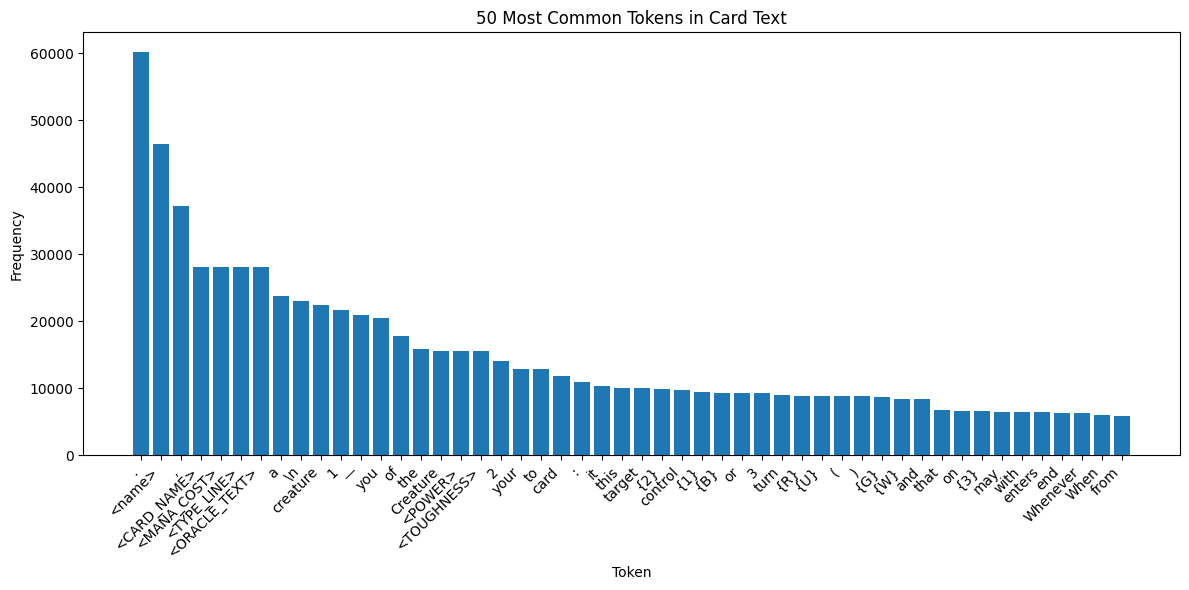

In [153]:
from nltk.probability import FreqDist
from collections import Counter

# Flatten all tokens into a single list
all_tokens = [token for tokens in tokenized_texts for token in tokens if token]

# Calculate frequency distribution
freq_dist = FreqDist(all_tokens)

# Get the 20 most common tokens
most_common = freq_dist.most_common(50)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in most_common], [x[1] for x in most_common])
plt.xticks(rotation=45, ha='right')
plt.title('50 Most Common Tokens in Card Text')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.tight_layout()

# Print statistics
print(f"Total tokens: {len(all_tokens)}")
print(f"Unique tokens: {len(set(all_tokens))}")
print("\nMost common tokens:")
for token, count in most_common:
    print(f"{token}: {count}")

# Generate dataset

In [154]:
dataset_without_name = relevant_cards_without_name[["card_text", "themes", "card_text_tokens", "themes_tokens"]]

In [155]:
dataset_without_name

,card_text,themes,card_text_tokens,themes_tokens
0,<CARD_NAME> <name> <MANA_COST> {3} <TYPE_LINE>...,"[N Identity, Artifact, N Color, {3} Cost]","[<CARD_NAME>, <name>, <MANA_COST>, {3}, <TYPE_...","[<THEMES>, N, Identity, ,, Artifact, ,, N, Col..."
1,<CARD_NAME> <name> <MANA_COST> {U} <TYPE_LINE>...,"[{U} Cost, Aura, Enchantment, U Identity, Crea...","[<CARD_NAME>, <name>, <MANA_COST>, {U}, <TYPE_...","[<THEMES>, {U}, Cost, ,, Aura, ,, Enchantment,..."
2,<CARD_NAME> <name> <MANA_COST> {G}{G} <TYPE_LI...,"[Entwine, G Identity, {G}{G} Cost, G Color, So...","[<CARD_NAME>, <name>, <MANA_COST>, {G}, {G}, <...","[<THEMES>, Entwine, ,, G, Identity, ,, {G}, {G..."
3,<CARD_NAME> <name> <MANA_COST> {1}{U} <TYPE_LI...,"[Token, Bird, Creature, Cost, Flying, U Ident...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {U}, <...","[<THEMES>, Token, ,, Bird, ,, Creature, ,, Cos..."
4,<CARD_NAME> <name> <MANA_COST> {B} <TYPE_LINE>...,"[B Identity, Creature, Suspect, Rat, Creature ...","[<CARD_NAME>, <name>, <MANA_COST>, {B}, <TYPE_...","[<THEMES>, B, Identity, ,, Creature, ,, Suspec..."
...,...,...,...,...
28074,<CARD_NAME> <name> <MANA_COST> {W} <TYPE_LINE>...,"[Creature, {W} Cost, Soldier, W Color, Elf, W ...","[<CARD_NAME>, <name>, <MANA_COST>, {W}, <TYPE_...","[<THEMES>, Creature, ,, {W}, Cost, ,, Soldier,..."
28075,<CARD_NAME> <name> <MANA_COST> {1}{B} <TYPE_LI...,"[B Identity, Indestructible, Cycling, Creature...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {B}, <...","[<THEMES>, B, Identity, ,, Indestructible, ,, ..."
28076,<CARD_NAME> <name> <MANA_COST> {4}{R}{W} <TYPE...,"[RW Identity, Lifelink, Damage, Creature, Mino...","[<CARD_NAME>, <name>, <MANA_COST>, {4}, {R}, {...","[<THEMES>, RW, Identity, ,, Lifelink, ,, Damag..."
28077,<CARD_NAME> <name> <MANA_COST> {2}{R}{G} <TYPE...,"[Damage, Double Strike, Planeswalker, {2}{R}{G...","[<CARD_NAME>, <name>, <MANA_COST>, {2}, {R}, {...","[<THEMES>, Damage, ,, Double, Strike, ,, Plane..."


In [156]:
def add_end_token(entry):
    entry["card_text_tokens"].append("[end]")

def add_start_token(entry):
    entry["themes_tokens"].insert(0, "[start]")

dataset_without_name.apply(add_end_token, axis=1)
dataset_without_name.apply(add_start_token, axis=1)
dataset_without_name

,card_text,themes,card_text_tokens,themes_tokens
0,<CARD_NAME> <name> <MANA_COST> {3} <TYPE_LINE>...,"[N Identity, Artifact, N Color, {3} Cost]","[<CARD_NAME>, <name>, <MANA_COST>, {3}, <TYPE_...","[[start], <THEMES>, N, Identity, ,, Artifact, ..."
1,<CARD_NAME> <name> <MANA_COST> {U} <TYPE_LINE>...,"[{U} Cost, Aura, Enchantment, U Identity, Crea...","[<CARD_NAME>, <name>, <MANA_COST>, {U}, <TYPE_...","[[start], <THEMES>, {U}, Cost, ,, Aura, ,, Enc..."
2,<CARD_NAME> <name> <MANA_COST> {G}{G} <TYPE_LI...,"[Entwine, G Identity, {G}{G} Cost, G Color, So...","[<CARD_NAME>, <name>, <MANA_COST>, {G}, {G}, <...","[[start], <THEMES>, Entwine, ,, G, Identity, ,..."
3,<CARD_NAME> <name> <MANA_COST> {1}{U} <TYPE_LI...,"[Token, Bird, Creature, Cost, Flying, U Ident...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {U}, <...","[[start], <THEMES>, Token, ,, Bird, ,, Creatur..."
4,<CARD_NAME> <name> <MANA_COST> {B} <TYPE_LINE>...,"[B Identity, Creature, Suspect, Rat, Creature ...","[<CARD_NAME>, <name>, <MANA_COST>, {B}, <TYPE_...","[[start], <THEMES>, B, Identity, ,, Creature, ..."
...,...,...,...,...
28074,<CARD_NAME> <name> <MANA_COST> {W} <TYPE_LINE>...,"[Creature, {W} Cost, Soldier, W Color, Elf, W ...","[<CARD_NAME>, <name>, <MANA_COST>, {W}, <TYPE_...","[[start], <THEMES>, Creature, ,, {W}, Cost, ,,..."
28075,<CARD_NAME> <name> <MANA_COST> {1}{B} <TYPE_LI...,"[B Identity, Indestructible, Cycling, Creature...","[<CARD_NAME>, <name>, <MANA_COST>, {1}, {B}, <...","[[start], <THEMES>, B, Identity, ,, Indestruct..."
28076,<CARD_NAME> <name> <MANA_COST> {4}{R}{W} <TYPE...,"[RW Identity, Lifelink, Damage, Creature, Mino...","[<CARD_NAME>, <name>, <MANA_COST>, {4}, {R}, {...","[[start], <THEMES>, RW, Identity, ,, Lifelink,..."
28077,<CARD_NAME> <name> <MANA_COST> {2}{R}{G} <TYPE...,"[Damage, Double Strike, Planeswalker, {2}{R}{G...","[<CARD_NAME>, <name>, <MANA_COST>, {2}, {R}, {...","[[start], <THEMES>, Damage, ,, Double, Strike,..."


In [218]:
x_data = list()
y_data = list()
for index, entry in dataset_without_name.iterrows():
    print(f"{index}/{len(dataset_without_name)} rows                     ", end="\r")
    card_text_tokens = entry["card_text_tokens"]
    themes_tokens = entry["themes_tokens"]

    for i in range(len(card_text_tokens)):
        current_tokens = themes_tokens + card_text_tokens[:i]
        next_token = card_text_tokens[i]

        x_data.append(" ".join(current_tokens))
        y_data.append(next_token)

28078/28079 rows                     

In [219]:
training_data = pd.DataFrame({"sentence": x_data, "prediction": y_data})
training_data

,sentence,prediction
0,"[start] <THEMES> N Identity , Artifact , N Col...",<CARD_NAME>
1,"[start] <THEMES> N Identity , Artifact , N Col...",<name>
2,"[start] <THEMES> N Identity , Artifact , N Col...",<MANA_COST>
3,"[start] <THEMES> N Identity , Artifact , N Col...",{3}
4,"[start] <THEMES> N Identity , Artifact , N Col...",<TYPE_LINE>
...,...,...
1267820,"[start] <THEMES> Creature , W Color , Creature...",<POWER>
1267821,"[start] <THEMES> Creature , W Color , Creature...",1
1267822,"[start] <THEMES> Creature , W Color , Creature...",<TOUGHNESS>
1267823,"[start] <THEMES> Creature , W Color , Creature...",1


In [220]:
print(training_data["sentence"].iloc[1267824])
print(training_data["prediction"].iloc[1267824])

[start] <THEMES> Creature , W Color , Creature Based , {1} {W} Cost , Sliver , W Identity <CARD_NAME> <name> <MANA_COST> {1} {W} <TYPE_LINE> Creature — Sliver <ORACLE_TEXT> All Sliver creatures get 1 1 . <POWER> 1 <TOUGHNESS> 1
[end]


In [221]:
training_data.to_csv("../data/processed/training_data.csv")

# Split into Training and Test data

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    training_data["sentence"],
    training_data["prediction"],
    test_size=0.1,
    random_state=42)

In [15]:
train = pd.DataFrame({"sentence": x_train, "prediction": y_train})
test = pd.DataFrame({"sentence": x_test, "prediction": y_test})

In [16]:
train.to_csv("../data/dataset/train.tsv", sep="\t")
test.to_csv("../data/dataset/test.tsv", sep="\t")

# Train TextVectorization layer on input

In [6]:
training_data = pd.read_csv("../data/processed/training_data.csv", index_col=0)

In [7]:
training_data

,sentence,prediction
0,"[start] <THEMES> N Identity , Artifact , N Col...",<CARD_NAME>
1,"[start] <THEMES> N Identity , Artifact , N Col...",<name>
2,"[start] <THEMES> N Identity , Artifact , N Col...",<MANA_COST>
3,"[start] <THEMES> N Identity , Artifact , N Col...",{3}
4,"[start] <THEMES> N Identity , Artifact , N Col...",<TYPE_LINE>
...,...,...
1267820,"[start] <THEMES> Creature , W Color , Creature...",<POWER>
1267821,"[start] <THEMES> Creature , W Color , Creature...",1
1267822,"[start] <THEMES> Creature , W Color , Creature...",<TOUGHNESS>
1267823,"[start] <THEMES> Creature , W Color , Creature...",1


In [8]:
text_vectorization = tf.keras.layers.TextVectorization(
    standardize=None,
    max_tokens=4500,
    output_mode="int",
    output_sequence_length=205)

I0000 00:00:1740937023.986535   40846 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5


In [9]:
def build_training_sequence(entry):
    # Add prediction to the end so text vectorization layer gets the "[end]" token.
    return entry["sentence"] + " " + entry["prediction"]

training_sequences = training_data.apply(build_training_sequence, axis=1)
text_vectorization.adapt(training_sequences)

2025-03-02 10:37:20.372349: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1003575328 exceeds 10% of free system memory.
2025-03-02 10:37:20.372486: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1505362992 exceeds 10% of free system memory.


In [10]:
text_vectorization(training_sequences[0])

<tf.Tensor: shape=(205,), dtype=int64, numpy=
array([ 8,  9, 50,  6,  2, 37,  2, 50,  7,  2, 29,  5, 10,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])>

In [11]:
vocabulary = text_vectorization.get_vocabulary()
vocabulary_size = text_vectorization.vocabulary_size()

In [12]:
vocabulary_size

4243

In [13]:
prediction_vocab_indices = training_data["prediction"].apply(lambda x: vocabulary.index(x))
prediction_vocab_indices

0           10
1            4
2           11
3           29
4           12
          ... 
1267820    112
1267821     26
1267822    162
1267823     26
1267824    234
Name: prediction, Length: 1267825, dtype: int64

# Set up the model

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dims, seq_len):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 1, embed_dims)
        self.pos_embedding = tf.keras.layers.Embedding(seq_len, embed_dims, mask_zero=True)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        index_range = tf.shape(x)[-1]
        y = self.embedding(x)
        indices = tf.range(index_range)
        pos = self.pos_embedding(indices)
        return y + pos

In [ ]:
class DecoderSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super().__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim)
        
    def call(self, x):
        y = self.attention(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True)
        return y

In [ ]:
VOCAB_SIZE = 8912 # Define this based on training data vocab size / tokenize size.
# TODO: Or does it need to relate to the tokenizer?
SEQUENCE_LENGTH = 500 # Define this based on training data sequence length.
EMBEDDING_DIM = 512 # Configure
FEED_FORWARD_DIM = 4 * EMBEDDING_DIM # This is usual value used by other LLMs, from below reference.
DROPOUT = 0.5 # Configure
NUM_HEADS = 16 # Configure
NUM_DECODER_LAYERS = 4 # Configure

### Reference: https://cameronrwolfe.substack.com/p/decoder-only-transformers-the-workhorse

decoder_inputs = tf.keras.Input(shape=(None,), dtype=tf.int64, name="decoder_inputs")
positional_embedding = PositionalEmbedding(
    VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH)(decoder_inputs)

layer_input = positional_embedding
layer_output = None
for i in range(NUM_DECODER_LAYERS):
    decoder_norm_1 = tf.keras.layers.LayerNormalization()(layer_input)
    decoder_self_attention = DecoderSelfAttention(NUM_HEADS, EMBEDDING_DIM)(decoder_norm_1)
    decoder_add_1 = tf.keras.layers.Add()([decoder_self_attention, decoder_norm_1])
    decoder_norm_2 = tf.keras.layers.LayerNormalization()(decoder_add_1)
    decoder_feedforward_1 = tf.keras.layers.Dense(FEED_FORWARD_DIM, activation="gelu")(decoder_norm_2)
    decoder_feedforward_2 = tf.keras.layers.Dense(EMBEDDING_DIM)(decoder_feedforward_1)
    decoder_dropout = tf.keras.layers.Dropout(DROPOUT)(decoder_feedforward_2)
    decoder_add_2 = tf.keras.layers.Add()([decoder_dropout, decoder_add_1])

    layer_input = decoder_add_2
    layer_output = decoder_add_2

prediction = tf.keras.layers.Dense(VOCAB_SIZE, activation="softmax")(layer_output)
transformer = tf.keras.models.Model(
    inputs=decoder_inputs, outputs=prediction, name="transformer")

In [ ]:
transformer.summary()

In [ ]:
history = transformer.fit(
    x,
    y,
    batch_size=100,
    epochs=5,
    shuffle=True)